# Navigation

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
#!pip install numpy>=1.13.3
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [18]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [19]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.          1.          0.          0.          0.16895212  0.          1.
  0.          0.          0.20073597  1.          0.          0.          0.
  0.12865657  0.          1.          0.          0.          0.14938059
  1.          0.          0.          0.          0.58185619  0.          1.
  0.          0.          0.16089135  0.          1.          0.          0.
  0.31775284  0.          0.        ]
States have length: 37


### 3. ANN model and agent-environment interactions

Run the next code cell to import a necessary packages. 

In [20]:
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random

Parameters of the simulation as well as architecture of the ANN: 

In [21]:
# Training Parameters

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 30
GAMMA = 0.98
TAU = 1e-3
LR = 1e-3
UPDATE_EVERY = 3

# Network architecture (hiden layer size)

h1_size = 64
h2_size = 256
h3_size = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class DeepQNetwork(nn.Module):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 seed: int,
                 fc1: int,
                 fc2: int,
                 fc3: int):
        """
        Initialize parameters and build model.
        
        Parameters:
        __________

        state_size: dimension of each state
        action_size: dimension of each action
        seed: random seed
        fc1_units: first hidden layer size
        fc2_units: second hidden layer size
        fc3_units: third hidden layer size

        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, fc3)
        self.fc4 = nn.Linear(fc3, action_size)

    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [26]:
class Agent():

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 seed:float):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork = DeepQNetwork(state_size, action_size, seed, h1_size, h2_size, h3_size).to(device)
        self.qnetwork_target = DeepQNetwork(state_size, action_size, seed, h1_size, h2_size, h3_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self,
             state:any,
             action:int,
             reward:float,
             next_state:any,
             done: bool):

        self.memory.add(state, action, reward, next_state, done)                    # save experience

        self.t_step = (self.t_step + 1) % UPDATE_EVERY                              # update at timesteps
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self,
            state: any,
            eps: float=0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork(state)
        self.qnetwork.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self,
              experiences:any,
              gamma:float):

        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork, self.qnetwork_target, TAU)

    def soft_update(self,
                    local_model:any,
                    target_model:any,
                    tau:float):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class ReplayBuffer:

    def __init__(self, 
                 action_size:int,
                 buffer_size:int,
                 batch_size:int,
                 seed:float):
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self,
            state:any,
            action:int,
            reward:float,
            next_state:any,
            done:bool):
        
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self)->tuple:
        
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [29]:
def dqn(agent,
        n_episodes=1000,
        max_t=1000, 
        eps_start = 1.0,
        eps_end=0.1,
        eps_decay=0.99,
        train=True):

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]               # reset environment
        state = env_info.vector_observations[0]                         # get state
        score = 0

        for t in range(max_t):
            
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]                     # action step
            next_state = env_info.vector_observations[0]                # get the next state
            reward = env_info.rewards[0]                                # acquire reward
            done = env_info.local_done[0]                               # check if episode is done
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state                                          # update state
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)                             # update epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            torch.save(agent.qnetwork.state_dict(), 'checkpoint.pth')
            break

    return scores

In [30]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
score = dqn(agent)

Episode 100	Average Score: 2.25
Episode 200	Average Score: 7.59
Episode 300	Average Score: 11.54
Episode 400	Average Score: 11.99
Episode 471	Average Score: 13.03

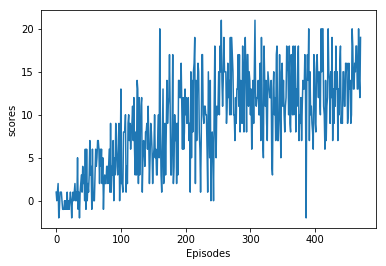

In [31]:
plt.plot(np.arange(len(score)), score)
plt.ylabel('scores')
plt.xlabel('Episodes')
plt.savefig("progress.jpeg")
plt.show()